In [1]:
import nltk
from nltk.stem.porter import *
from nltk.classify import MaxentClassifier
import tensorflow as tf
import numpy as np
from io import open
import os
print(os.getcwd())

/kaggle/working


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel
glovemod=loadGloveModel("/kaggle/input/glove6b50dtxt/glove.6B.50d.txt")

Loading Glove Model
400000  words loaded!


In [4]:
boi_full_list = [] #store all the boi tags that occur in the training set
BO_list = ['B', 'I','O']
labeled_features = []
wordStartList = []
boi_end_list = []

In [5]:
POS_dict={'X':0}
poscnt=1
with open("/kaggle/input/conll-corpora/conll2000/conll2000/train.txt", "r") as f:
    for line in f:
        line=line.strip()
        if line!='':
            POS_tag=line.split()[1]
            if POS_tag not in POS_dict:
                POS_dict[POS_tag]=poscnt
                poscnt+=1
def get_vector_POS(tag):
    ans=[0]*len(POS_dict)
    ans[POS_dict[tag]]=1
    return ans

In [6]:
print(POS_dict)
# print("hey")
# output_file = open("bo_output.txt", "wb")

{'X': 0, 'NN': 1, 'IN': 2, 'DT': 3, 'VBZ': 4, 'RB': 5, 'VBN': 6, 'TO': 7, 'VB': 8, 'JJ': 9, 'NNS': 10, 'NNP': 11, ',': 12, 'CC': 13, 'POS': 14, '.': 15, 'VBP': 16, 'VBG': 17, 'PRP$': 18, 'CD': 19, '``': 20, "''": 21, 'VBD': 22, 'EX': 23, 'MD': 24, '#': 25, '(': 26, '$': 27, ')': 28, 'NNPS': 29, 'PRP': 30, 'JJS': 31, 'WP': 32, 'RBR': 33, 'JJR': 34, 'WDT': 35, 'WRB': 36, 'RBS': 37, 'PDT': 38, 'RP': 39, ':': 40, 'FW': 41, 'WP$': 42, 'SYM': 43, 'UH': 44}


In [7]:
boi_full_list = [] #store all the boi tags that occur in the training set
labeled_features = []
wordStartList = []
boi_end_list = []
training_file = open("/kaggle/input/conll-corpora/conll2000/conll2000/train.txt", "r")
previous_BOI = "start"
input_file = training_file
change_of_sentence_flag=1
st = False
i = 0
for line in input_file:
    #print(line)
    s = re.match(r'^\s*$', line)  #find empty line
    if s:
        i=0
        change_of_sentence_flag = 1
        previous_BOI = "start"
    else: 
        sentenceList = line.split()
        word = sentenceList[0]
        tag = sentenceList[1]
        boi = (sentenceList[2].split('-'))[0]
        #print(boi)
        
        #store words that are begining of the sentence
        if change_of_sentence_flag == 1:
            wordStartList.append(word)
            if st:
                boi_end_list.append(boi_full_list[-1])
            change_of_sentence_flag = 0
        boi_full_list.append(boi)
        prev_w, prev_t, prev_w2, prev_t2, prev_bi, prev_bi2 = 'X', 'X', 'X', 'X', 'start', 'start'
        next_w, next_t, next_w2, next_t2 = 'X', 'X', 'X', 'X'
        if i>0:
            prev_w = labeled_features[-1][0]
            prev_t = labeled_features[-1][1]
            prev_bi = labeled_features[-1][2]
            labeled_features[-1][9] = word
            labeled_features[-1][10] = tag
        if i>1:
            prev_w2 = labeled_features[-2][0]
            prev_t2 = labeled_features[-2][1]
            prev_bi2 = labeled_features[-2][2]
            labeled_features[-2][11] = word
            labeled_features[-2][12] = tag
        item = [word, tag, boi, prev_w, prev_t, prev_bi, prev_w2, prev_t2,prev_bi2, next_w, next_t, next_w2, next_t2 ]
        #print(item) if s:
        w=0
        change_of_sentence_flag = 1
        previous_BOI = "start"
#         test_data.append(small_list)
#         test_labels.append(boi_list)
        labeled_features.append(item)
        previous_BOI = boi
        st = True
        i+=1
        #labeled_features 

boi_end_list.append(boi_full_list[-1])
# print("labeled_features")
# print(labeled_features)
#unlabeled_features = []

input_file.close()

In [8]:
[print(x) for x in labeled_features[35:40]]

['deficits', 'NNS', 'I', 'near-record', 'JJ', 'I', "'s", 'POS', 'B', '.', '.', 'X', 'X']
['.', '.', 'O', 'deficits', 'NNS', 'I', 'near-record', 'JJ', 'I', 'X', 'X', 'X', 'X']
['Chancellor', 'NNP', 'O', 'X', 'X', 'start', 'X', 'X', 'start', 'of', 'IN', 'the', 'DT']
['of', 'IN', 'B', 'Chancellor', 'NNP', 'O', 'X', 'X', 'start', 'the', 'DT', 'Exchequer', 'NNP']
['the', 'DT', 'B', 'of', 'IN', 'B', 'Chancellor', 'NNP', 'O', 'Exchequer', 'NNP', 'Nigel', 'NNP']


[None, None, None, None, None]

In [9]:
stemmer = PorterStemmer()
print(len(labeled_features))

211727


In [10]:
def MEMM_features(item):
    # 0word, 1tag, 2boi, 3prev_w, 4prev_t, 5prev_bi, 6prev_w2, 7prev_t2,8prev_bi2, 9next_w, 10next_t, 11next_w2, 12next_t2  
    features = {}
    allbois=['B', 'I','O','start']
    emb1 = glovemod.get(item[0].lower(),glovemod['.'])
    for j in range(emb1.shape[0]):
            features["cw"+str(j)]=emb1[j]
            
    emb1 = glovemod.get(item[3].lower(),glovemod['.'])
    for j in range(emb1.shape[0]):
            features["pw"+str(j)]=emb1[j]
    
    emb1 = glovemod.get(item[6].lower(),glovemod['.'])
    for j in range(emb1.shape[0]):
            features["pw2"+str(j)]=emb1[j]
            
    emb1 = glovemod.get(item[9].lower(),glovemod['.'])
    for j in range(emb1.shape[0]):
            features["nw"+str(j)]=emb1[j]
            
    emb1 = glovemod.get(item[11].lower(),glovemod['.'])
    for j in range(emb1.shape[0]):
            features["nw2"+str(j)]=emb1[j]

    cnter=0
    for x in get_vector_POS(item[1]):
        features['current_tag'+str(cnter)]=x
        cnter+=1
    
    cnter=0
    for x in get_vector_POS(item[4]):
        features['prev_tag'+str(cnter)]=x
        cnter+=1
    cnter=0
    for x in get_vector_POS(item[7]):
        features['[prev_tag2'+str(cnter)]=x
        cnter+=1
    cnter=0
    for x in get_vector_POS(item[10]):
        features['next_tag'+str(cnter)]=x
        cnter+=1
    cnter=0
    for x in get_vector_POS(item[12]):
        features['next_tag2'+str(cnter)]=x
        cnter+=1   
#     features['current_tag'] = item[1]
#     features['prev_tag'] = item[4]
#     features['prev_tag2'] = item[7]
#     features['next_tag'] = item[10]
#     features['next_tag2'] = item[12]
    for i in range(4):
        features['prev_bi'+str(i)]=0
    features['prev_bi'+str(allbois.index(item[5]))]=1
#     features['prev_bi2'] = item[8]
#     puc = '-'.decode("utf-8")
#      #some char is outof ASCII
#     print (word)
    features['capitalization'] = int(word[0].isupper())
    features['start_of_sentence'] = int(word in wordStartList)
    features['cap_start'] = int(word not in wordStartList and word[0].isupper())
    #features['suffix'] =  item[0].replace(stemmer.stem(item[0]),"")
    #features['previous_NC'] = previous_BOI
    token = item[0]
    features['ends_with_ly']    = float(token.endswith('ly'))
    features['ends_with_ment']  = float(token.endswith('ment'))
    features['ends_with_able']  = float(token.endswith('able') or token.endswith('ible'))
    features['ends_with_fy' ]   = float(token.endswith('fy'))
    features['ends_with_al']    = float(token.endswith('al'))
#     print(token)
#     print(features['ends_with_ly'])
    f1=list(features.items())
    features=[x[1] for x in f1]
    return features

In [11]:
r=np.array(MEMM_features(labeled_features[0]))
#print(r)
print(r.dtype)

float64


In [12]:
labeled_featuresets = [MEMM_features(item) for item in labeled_features]
# r=np.array(labeled_featuresets)
# print(np.shape(r))
# print(r.dtype)

In [13]:
print(labeled_featuresets[0][-10:])

[0, 1, 0, 1, 0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [14]:
train_set = np.array(labeled_featuresets)
print(len(train_set))
#print(train_set[0])
print(train_set.dtype)

211727
float64


In [15]:
input_shape = train_set[0].shape[0]
BO_list = ['B', 'I','O']
train_labels=np.array([BO_list.index(x) for x in boi_full_list])

In [16]:
print((train_labels.dtype))

int64


In [17]:
print(train_set.shape)
print(train_set.dtype)
print(type(train_set[0]))
print(type(train_set))

(211727, 457)
float64
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [18]:
import tensorflow as tf
with strategy.scope():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(input_shape,)))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(len(BO_list), activation='softmax'))# changed here
    model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(0.001),metrics=['accuracy'])
    model.fit(x=train_set,y=train_labels,validation_split=0.1,epochs=5,batch_size = 128 * strategy.num_replicas_in_sync)

Epoch 1/5
1489/1489 [==============================] - 2s 1ms/step - loss: 0.3983 - accuracy: 0.8560 - val_loss: 0.2571 - val_accuracy: 0.9183
Epoch 2/5
1489/1489 [==============================] - 2s 1ms/step - loss: 0.2287 - accuracy: 0.9269 - val_loss: 0.2072 - val_accuracy: 0.9335
Epoch 3/5
1489/1489 [==============================] - 2s 1ms/step - loss: 0.1986 - accuracy: 0.9350 - val_loss: 0.1905 - val_accuracy: 0.9392
Epoch 4/5
1489/1489 [==============================] - 2s 1ms/step - loss: 0.1865 - accuracy: 0.9379 - val_loss: 0.1821 - val_accuracy: 0.9410
Epoch 5/5
1489/1489 [==============================] - 2s 1ms/step - loss: 0.1805 - accuracy: 0.9396 - val_loss: 0.1775 - val_accuracy: 0.9424


In [19]:
import joblib
joblib.dump(train_set, 'train_features.pkl')
joblib.dump(train_labels,'train_labels.pkl')

['train_labels.pkl']

In [20]:
# dicE = {} #temporarry dic 
# countTag = 0
# countEnd = 0
# #calculate the prior (End|state) = C(state, End)/C(state) 
# for i in BO_list:
#     for j  in range(len(boi_end_list)):
#         for f in boi_full_list:
#             if j == 0:
#                 if i == f:
#                     countTag = countTag + 1 
#         if i == boi_end_list[j]:
#             countEnd = countEnd + 1 
#     ProbE = format(countEnd/(countTag*1.0), '.5f')
#     dicE.update({i: {"END":ProbE}})

#     countEnd = 0
#     countTag = 0

In [21]:
def MEMM(preds):
    BOI_list = ['B', 'I','O']
    tRange = len(BOI_list)
    wRange = int(len(preds)//3+1)
    #print(wRange)
#     w1 = wordList[0] #the first word of the sentence
#     t1 = tagList[0]
#     wp1 = 'X'
#     wp2 = 'X'
#     tp1 = 'X'
#     tp2 = 'X'
#     wn1 = 'X' if wRange<2 else wordList[1]
#     wn2 = 'X' if wRange<3 else wordList[2]
#     tn1 = 'X' if wRange<2 else tagList[1]
#     tn2 = 'X' if wRange<3 else tagList[2]
    
    #word, tag, boi, prev_w, prev_t, prev_bi, prev_w2, prev_t2, next_w, next_t, next_w2, next_t2

    max_len = 300
    viterbi = [[0 for x in range(max_len)] for x in range(max_len)] 
    backpointer = [['' for x in range(max_len)] for x in range(max_len)] 
    #intialization
    #item = [w1, t1, 'BIO', wp1, tp1, 'start', wp2, tp2,'start', wn1, tn1, wn2, tn2 ]
    #probability = model.predict(np.array([MEMM_features(item)]))
    for t in range(tRange):#t = 0,1,2
        posterior = float(preds[0][t])
        #print ("boi: " + BOI_list[t] + ' posterior (start)' + str(posterior))
        #score transition 0(start) -> q given w1
        viterbi[t][1] = posterior
        backpointer[t][1] = 0 #stand for q0 (start point)

    #for word w from 2 to T
    maxViterbi = 0
    maxPreviousState = 0 
    maxPreTerminalProb = 0
    for w in range (1, wRange):
#         w1 = wordList[w] #the first word of the sentence
#         t1 = tagList[w]
#         wp1 = wordList[w-1]
#         wp2 = 'X' if w<2 else wordList[w-2]
#         tp1 = tagList[w-1]
#         tp2 = 'X' if w<2 else tagList[w-2]
#         wn1 = 'X' if w>wRange-2 else wordList[w+1]
#         wn2 = 'X' if w>wRange-3 else wordList[w+2]
#         tn1 = 'X' if w>wRange-2 else tagList[w+1]
#         tn2 = 'X' if w>wRange-3 else tagList[w+2]
#         item = [w1, t1, 'BIO', wp1, tp1, 'BIO', wp2, tp2,'ununsed', wn1, tn1, wn2, tn2 ]
#         pr = [0 for x in range(tRange)]
#         for t in range(tRange):
#             item[5]=BOI_list[t]
#             pr[t] = model.predict(np.array([MEMM_features(item)])) 
        for t in range (tRange):
            #find max verterbi = max (previous * posterior)	
#             word = wordList[w]
#             tag = tagList[w]
            #probability = maxent_classifier.prob_classify(MEMM_features(word,tag,BOI_list[0] )) 
            posterior = float(preds[(w-1)*3+1][t])
            maxViterbi = float(viterbi[0][w]) * posterior
            maxPreviousState = 0
            for i in range (1, tRange):
#                 word = wordList[w]
#                 tag = tagList[w]
#                 probability = maxent_classifier.prob_classify(MEMM_features(word,tag,BOI_list[i] )) 
                posterior = float(preds[(w-1)*3+1+i][t])
                if float(viterbi[i][w]) * posterior > maxViterbi:
                    maxViterbi = float(viterbi[i][w]) * posterior
                    maxPreviousState = i #content BOI_List[i]
            viterbi[t][w+1] = maxViterbi
            backpointer[t][w+1] = BOI_list[maxPreviousState] #points to the matrix x axis (max previous)

            maxViterbi = 0
            maxPreviousState = 0 
            maxPreTerminalProb = 0
    #termination step
    #viterbi[qF, T] = max (viterbi[s,T] *as,qF)
    maxPreTerminalProb = float(viterbi[0][wRange] )#* float(dicE[BOI_list[0]]["END"])
    
    maxPreviousState = 0
    for i in range (1, tRange):

        if float(viterbi[i][wRange]) > maxPreTerminalProb:
            maxPreTerminalProb = float(viterbi[i][wRange]) #* float(dicE[BOI_list[i]]["END"]) 

            maxPreviousState = i

#print ("maxPreTerminalProb: " + str(maxPreTerminalProb))
    viterbi[tRange][wRange+1] = maxPreTerminalProb 
    backpointer[tRange][wRange+1] = BOI_list[maxPreviousState]
#return POS tag path 
    pathReverse = [BOI_list[maxPreviousState]]
    maxPreviousTag = BOI_list[maxPreviousState]

    i = 0
    while i < (wRange -1):
        pathReverse.append(backpointer[BOI_list.index(maxPreviousTag)][wRange - i])
        maxPreviousTag = backpointer[BOI_list.index(maxPreviousTag)][wRange - i]
        i = i + 1 

#reverse the path to make it correct
    index = len(pathReverse)
    path = []
    while index >= 1 :
        path.append(pathReverse[index - 1])
        index = index -1 
    return path

In [22]:
testing_file = open("/kaggle/input/conll-corpora/conll2000/conll2000/test.txt", "r")
wordList = [] #store words in a sentence
tagList = [] #store part-of-speech tag in a sentence 
boiList = [] #store boi tags in a sentence 
ind_list=[]
indl_list = []
boi_list=[]
allWords = []
#prob_table = {} #stpre the posterior
previous_BOI = "start"
BOI_list = ['B', 'I','O']
tRange = len(BOI_list)
tot_corr=0
tot = 0

w=0
test_data = []
test_labels = []
input_file = testing_file
for line in input_file:
    
    if line.strip() != '': #if not empty do following 
        sentenceList = line.split()
        word = sentenceList[0]
        tag = sentenceList[1]
        boi = (sentenceList[2].split('-'))[0]
        wordList.append(word)
        tagList.append(tag)
        boiList.append(boi)
        wp1 = 'X' if w==0 else wordList[w-1]
        wp2 = 'X' if w<2 else wordList[w-2]
        tp1 = 'X' if w==0 else tagList[w-1]
        tp2 = 'X' if w<2 else tagList[w-2]
        wn1 = 'X' #if w>wRange-2 else wordList[w+1]
        wn2 = 'X' #if w>wRange-3 else wordList[w+2]
        tn1 = 'X' #if w>wRange-2 else tagList[w+1]
        tn2 = 'X' #if w>wRange-3 else tagList[w+2]
        item = [word, tag, 'BIO', wp1, tp1, 'BIO', wp2, tp2,'ununsed', wn1, tn1, wn2, tn2 ]
        if w==1:
            test_data[-1][9] = word
            test_data[-1][10] = tag
        elif w>1:
            for i in range(tRange):
                test_data[-1-i][9] = word
                test_data[-1-i][10] = tag
        if w==2:
            test_data[-1-tRange][11] = word
            test_data[-1-tRange][12] = tag
        elif w>2:
            for i in range(tRange):
                test_data[-1-tRange-i][11] = word
                test_data[-1-tRange-i][12] = tag
        if w==0:
            item1 = item.copy()
            item1[5] = "start"
            test_data.append(item1)
            #test_labels.append(boi)
        else:
            for i in range(tRange):
                item1 = item.copy()
                item1[5] = BOI_list[i]
                #print(BOI_list[i])
                test_data.append(item1)
                #test_labels.append(boi)
        w+=1
        test_labels.append(boi)
        #print (word, tag, boi)
#store words that are begining of the sentence
#store tags that are the begining of the sentence
#store the end of sentence tag in tagEndList
        if change_of_sentence_flag == 1:
            wordStartList.append(word)
            change_of_sentence_flag = 0
    s = re.match(r'^\s*$', line)  #find empty line
    if s:
        w=0
        change_of_sentence_flag = 1
        previous_BOI = "start"
        ind_list.append(len(test_data)-1)
        indl_list.append(len(test_labels)-1)
#         test_data.append(small_list)
#         test_labels.append(boi_list)
        #path = MEMM(wordList, tagList) #list of BOI_tags returned by HMM function call
#         print(path)
#         metric = np.array(boiList)==np.array(path)
#         acc = np.sum(metric)/len(path)
# #         print(boiList)
# #         print(path)
#         print(acc)
# #         print(metric)
#         tot_corr += np.sum(metric)
#         tot += len(path)
        allWords+=wordList
        wordList = [] # refresh word list
        tagList = []
        boiList = []
        #small_list = []
        #boi_list = []
        #break
        #prob_table = {}#refresh prob_table

input_file.close()
#print(tot_corr/tot)
#output_file.close()

In [23]:
print(test_data[1:4])
print(test_labels[0])
print(len(test_data))
print(len(test_labels))
print(len(ind_list))
print(len(indl_list))
print(ind_list[0:10])
print(indl_list[0:10])
print(len(allWords))

[['International', 'NNP', 'BIO', 'Rockwell', 'NNP', 'B', 'X', 'X', 'ununsed', 'Corp.', 'NNP', "'s", 'POS'], ['International', 'NNP', 'BIO', 'Rockwell', 'NNP', 'I', 'X', 'X', 'ununsed', 'Corp.', 'NNP', "'s", 'POS'], ['International', 'NNP', 'BIO', 'Rockwell', 'NNP', 'O', 'X', 'X', 'ununsed', 'Corp.', 'NNP', "'s", 'POS']]
B
138107
47377
2012
2012
[81, 130, 227, 282, 340, 413, 459, 514, 527, 624]
[27, 44, 77, 96, 116, 141, 157, 176, 181, 214]
47377


In [24]:
final_test = [MEMM_features(item) for item in test_data]
test_set = np.array(final_test)

In [25]:
print(len(test_set))
print(np.sum(test_set[1]==test_set[2]))
print(test_set.dtype)

138107
455
float64


In [26]:
print(test_set.shape)

(138107, 457)


In [27]:
BO_list = ['B', 'I','O']
test_labels_ind=np.array([BO_list.index(x) for x in test_labels])

In [28]:
with strategy.scope():
    predictions = model.predict(test_set)

In [29]:
prev = 0
prevl = 0
tot_corr = 0
tot = 0
final_pred = []
#len(ind_list)
for i in range(len(ind_list)):
    x1 = ind_list[i]
    x2 = indl_list[i]
    test_list = predictions[prev:x1+1]
    true_val = test_labels[prevl:x2+1]
    prev = x1+1
    prevl = x2+1
    path = MEMM(test_list)
    final_pred+=path
#     print(path)
#     print(true_val)
    metric = np.array(true_val)==np.array(path)
    acc = np.sum(metric)/len(path)
    #print(acc)
    tot_corr += np.sum(metric)
    tot += len(path)

print(tot_corr/tot)


0.9341452603584017


In [30]:
from matplotlib import pyplot as plt

In [31]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def get_report(y_true, y_pred, classes):
    clf_report = classification_report(y_true, y_pred, labels=classes, zero_division=0)
    clf_report = clf_report.replace('\n\n', '\n')
    clf_report = clf_report.replace('micro avg', 'micro_avg')
    clf_report = clf_report.replace('macro avg', 'macro_avg')
    clf_report = clf_report.replace('weighted avg', 'weighted_avg')
    clf_report = clf_report.replace(' / ', '/')
    lines = clf_report.split('\n')

    class_names, plotMat, support = [], [], []
    for line in lines[1:]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        v = [float(x) for x in t[1: len(t) - 1]]
        if len(v) == 1 : v = v * 3
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)
    plotMat = np.array(plotMat)
    support = np.array(support)
    return class_names, plotMat, support

def get_scores(y_true, y_pred, classes):
    correct, wrong = {}, {}
    for tag in classes:
        correct[tag] = 0
        wrong[tag] = 0
        
    for tag, pred in zip(y_true, y_pred):
        if tag == pred:
            correct[tag] += 1
        else:
            wrong[tag] += 1
            
    scores = []
    total = len(y_true)
    for tag in classes:
        cur = np.array([correct[tag], wrong[tag]])
        scores.append(cur / total)
    return np.array(scores)
    
def plot_confusion_matrix(classes, mat, normalize=True, cmap=plt.cm.Blues):
    cm = np.copy(mat)
    title = 'Confusion Matrix (without normalization)'
    if normalize:
        cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
        title = title.replace('without', 'with')
    plt.clf()    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.clim(vmin=0.0, vmax=1.0)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = np.max(cm) / 2
    thresh = 1 / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if (cm[i, j] > thresh) else "black"
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color=color)
    plt.ylabel('True label',fontsize=22)
    plt.xlabel('Predicted label', fontsize=22)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', bbox_inches="tight", transparent=True)
    plt.show()
    
def plot_clf_report(classes, plotMat, support, cmap=plt.cm.Blues):
    title = 'Classification Report'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(classes[idx], sup) for idx, sup in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(title, y=-0.06, fontsize=22)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=14)
    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.clim(vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=0)
    plt.yticks(np.arange(len(classes)), yticklabels)
    thresh = np.max(plotMat) / 2
    thresh = 1 / 2
    for i in range(plotMat.shape[0]):
        for j in range(plotMat.shape[1]):
            color = "white" if (plotMat[i, j] > thresh) else "black"
            plt.text(j, i, format(plotMat[i, j], '.2f'), horizontalalignment="center", color=color, fontsize=14)

    plt.xlabel('Metrics',fontsize=22)
    plt.ylabel('Classes',fontsize=22)
    plt.tight_layout()
    plt.savefig('classification_report.png', bbox_inches="tight", transparent=True)
    plt.show()
    
def plot_tag_scores(classes, scores, normalize=True):
    plt.clf()
    width = 0.45
    fig, ax = plt.subplots(figsize=(20,10))
    ax.xaxis.set_tick_params(labelsize=18, rotation=25)
    ax.yaxis.set_tick_params(labelsize=18)
    range_bar1 = np.arange(len(classes))
    rects1 = ax.bar(range_bar1, tuple(scores[:, 0]), width, color='b')
    rects2 = ax.bar(range_bar1 + width, tuple(scores[:, 1]), width, color='r')

    ax.set_ylabel('Scores',fontsize=22)
    ax.set_title('Tag scores', fontsize=22)
    ax.set_xticks(range_bar1 + width / 2)
    ax.set_xticklabels(classes)

    ax.legend((rects1[0], rects2[0]), ('Correct', 'Wrong'), fontsize=20)
    plt.legend()
    plt.savefig('tag_scores.png', bbox_inches="tight", transparent=True)
    plt.show()

47377
47377


<Figure size 432x288 with 0 Axes>

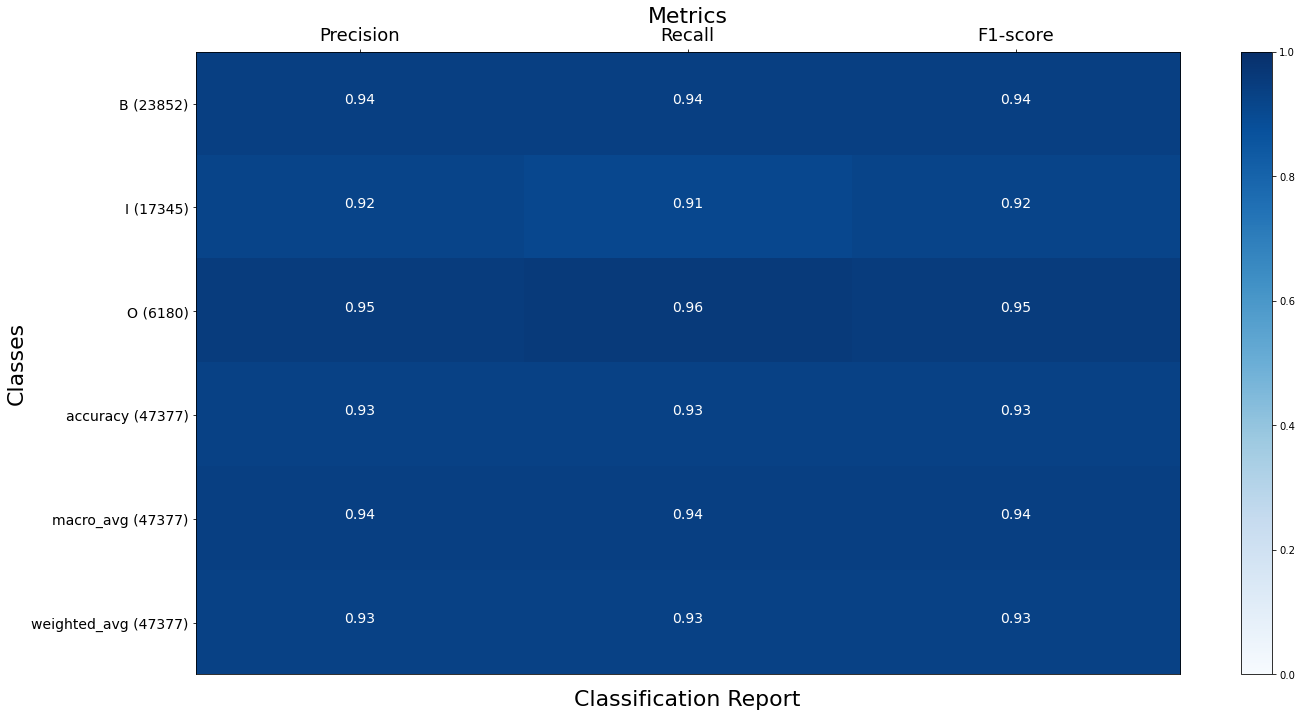

<Figure size 432x288 with 0 Axes>

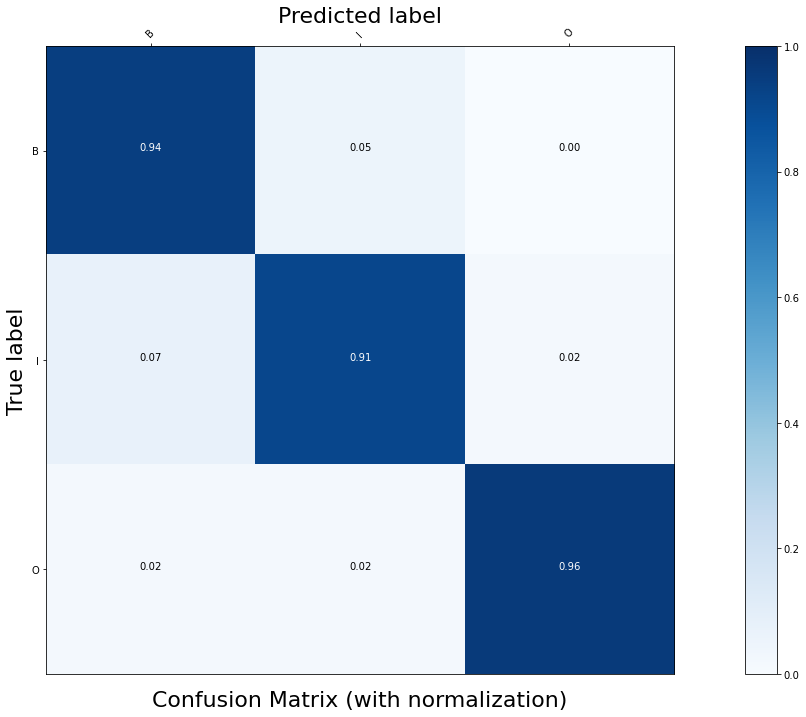

<Figure size 432x288 with 0 Axes>

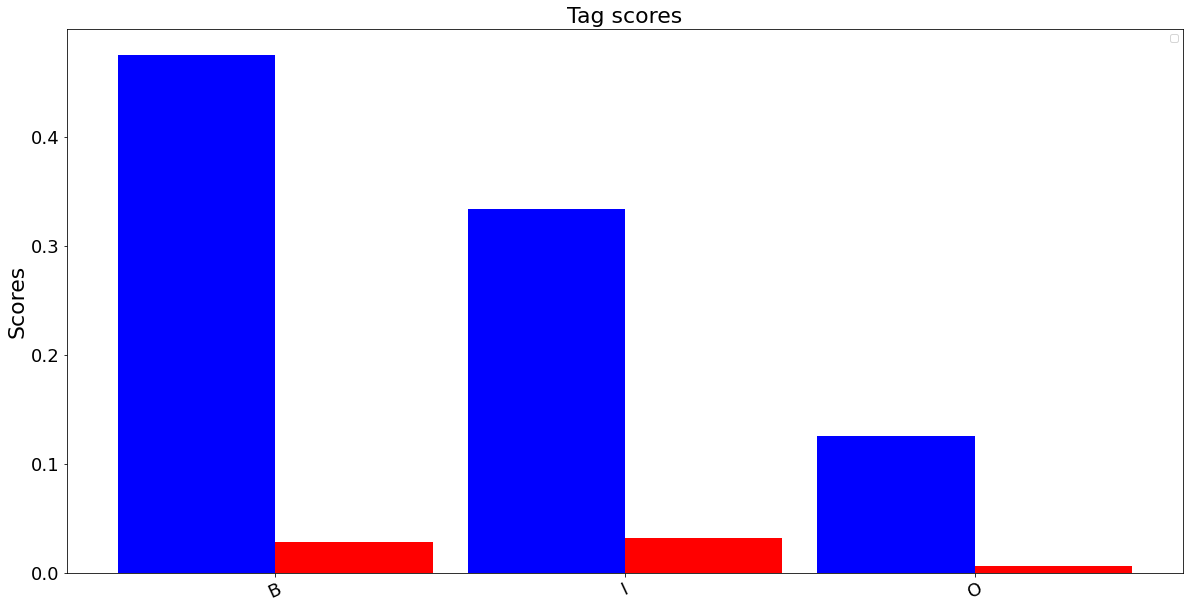

In [32]:
y_true=test_labels
y_pred=final_pred
print(len(y_true))
print(len(final_pred))
classes = ['B','I','O']
class_names, report, support = get_report(y_true, y_pred, classes)
cm = confusion_matrix(y_true, y_pred, labels=classes)
scores = get_scores(y_true, y_pred, classes)
plot_clf_report(class_names, report, support)
plot_confusion_matrix(classes, cm)
plot_tag_scores(classes, scores)

In [33]:
errswords=[]
correctlabels=[]
errlabels=[]
# ff=open('../input/chunking-preds/preds_pos.pkl','rb')
# allpreds=pickle.load(ff)
j=0
for i in range(len(test_labels)):
    if(i>indl_list[j]):
        j+=1
    if test_labels[i]!=final_pred[i]:
        errswords.append([allWords[i-1] if ((i>0 and j==0) or (j>0 and i>indl_list[j-1]+1)) else '##',allWords[i],allWords[i+1] if i<indl_list[j]-1 else '##'])
        correctlabels.append([test_labels[i-1] if ((i>0 and j==0) or (j>0 and i>indl_list[j-1]+1)) else '##',test_labels[i],test_labels[i+1] if i<indl_list[j]-1 else '##'])
        errlabels.append([final_pred[i-1] if ((i>0 and j==0) or (j>0 and i>indl_list[j-1]+1)) else '##',final_pred[i],final_pred[i+1] if i<indl_list[j]-1 else '##'])
# for x,y,z in zip(allWords,test_labels,final_pred):
#     for i in range(len(y)):
#         if y[i]!=z[i]:
# #             print('lol')
#             errswords.append([x[i-1] if i>0 else '##',x[i],x[i+1] if i<len(x)-1 else '##'])
#             correctlabels.append([y[i-1] if i>0 else '##',y[i],y[i+1] if i<len(y)-1 else '##'])
#             errlabels.append([z[i-1] if i>0 else '##',z[i],z[i+1] if i<len(z)-1 else '##'])

In [34]:
print(errswords[0])

['agreement', 'extending', 'its']


In [35]:
print(len(errswords))
[print((str(i[0])  if i[0]!=None else '##' )+' '+str(i[1])+' '+(str(i[2])  if i[2]!=None else '##' )+' ( correct: '+j[0]+' '+j[1]+' '+j[2]+ ' predicted: '+k[0]+' '+k[1]+' '+k[2]+' )') for i,j,k in zip(errswords[:100],correctlabels[:100],errlabels[:100])]

3120
agreement extending its ( correct: I B B predicted: I I B )
Co. to provide ( correct: I B I predicted: I I I )
These include , ( correct: B B O predicted: B I O )
aerospace , electronics ( correct: I I I predicted: I O B )
, electronics , ( correct: I I I predicted: O B O )
electronics , automotive ( correct: I I I predicted: B O B )
, automotive and ( correct: I I I predicted: O B I )
graphics concern ## ( correct: I I ## predicted: I B ## )
telecommunications company 's ( correct: I I B predicted: I B B )
vacancy created by ( correct: I B B predicted: I I B )
named president and ( correct: I B O predicted: I I O )
Skokie , Ill. ( correct: I I I predicted: I O B )
, Ill. , ( correct: I I I predicted: O B O )
Ill. , subsidiary ( correct: I I I predicted: B O B )
, subsidiary of ( correct: I I B predicted: O B B )
has interests in ( correct: B B B predicted: B I B )
is newly created ( correct: B I I predicted: B B I )
been executive vice ( correct: I B I predicted: I I I )
takes re

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]